In [10]:
from commonfunctions import *
%matplotlib inline
%load_ext autoreload
%autoreload 2
import pandas as pd
import cv2
import pytesseract
import skimage as ski
from skimage.filters import threshold_otsu
from skimage.morphology import binary_erosion, binary_dilation, binary_closing,skeletonize, thin
from skimage.measure import find_contours
from skimage.draw import rectangle
from skimage.filters import threshold_otsu

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [11]:
segs = [[220, 0], [760, 1], [1140, 2], [220, 3], [270, 4], [230, 5]]
#segs = [[220, 0], [780, 1], [1140, 2], [270, 3], [270, 4], [270, 5]]
def getImageBlocks(filtered_lines,inverted_img):
    idx = 0
    block_images = [] 
    for i in range(len(segs)):
        [block, nwidx] = getBlocks(filtered_lines[idx:], segs[i],inverted_img)
        idx = idx + nwidx
        block_images.append(block)  
    return block_images

8
3244
1890
11222
11222


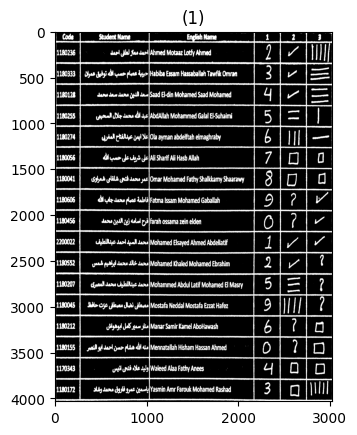

Detected and sorted vertical lines: [array([[  0, 126, 336, 126]], dtype=int32), array([[  0,  11, 285,  11]], dtype=int32), array([[   0, 1284,    0, 1104]], dtype=int32), array([[  1, 339, 211, 339]], dtype=int32), array([[   1, 1028,  186, 1028]], dtype=int32), array([[   1, 1045,  385, 1045]], dtype=int32), array([[   1, 1135,    1,  900]], dtype=int32), array([[  2, 569, 589, 569]], dtype=int32), array([[  2, 652,   2, 302]], dtype=int32), array([[  2, 817, 253, 817]], dtype=int32), array([[   9, 3532,    9, 3341]], dtype=int32), array([[   9, 2632,    9, 2113]], dtype=int32), array([[   9, 3108,  457, 3108]], dtype=int32), array([[   9, 3800,  215, 3800]], dtype=int32), array([[   9, 3937,  189, 3934]], dtype=int32), array([[  10, 4030,   10, 3465]], dtype=int32), array([[  10, 2112,   10, 1735]], dtype=int32), array([[  10, 3090,  613, 3090]], dtype=int32), array([[  10, 2189,  263, 2189]], dtype=int32), array([[  10, 2171,  404, 2171]], dtype=int32), array([[  11, 3320,  958, 3

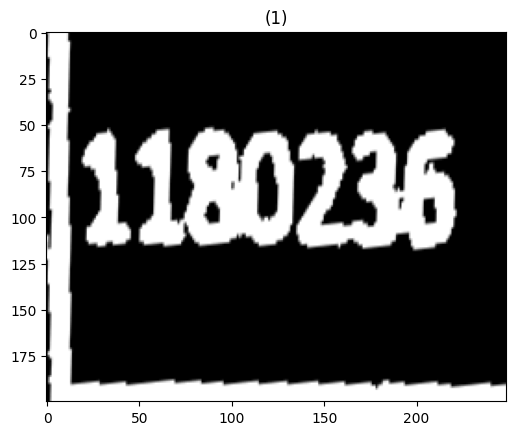

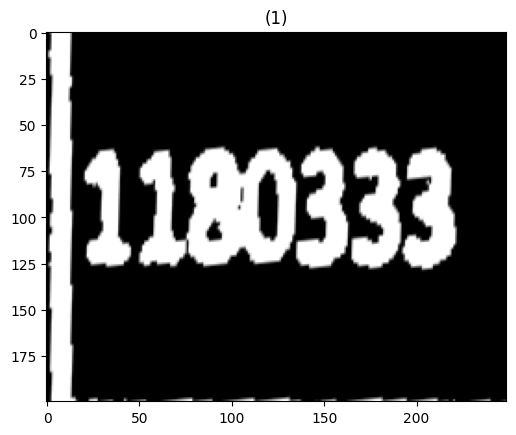

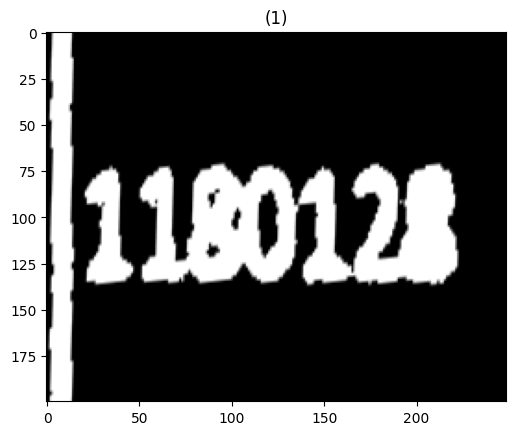

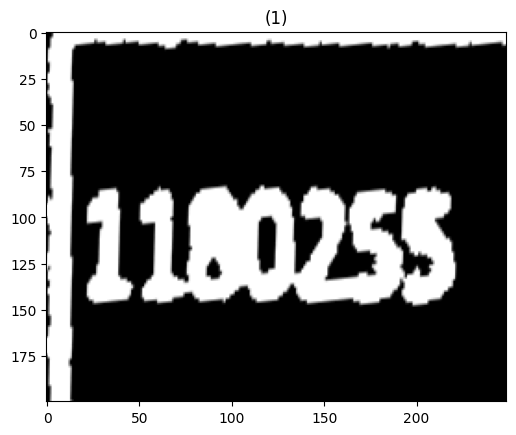

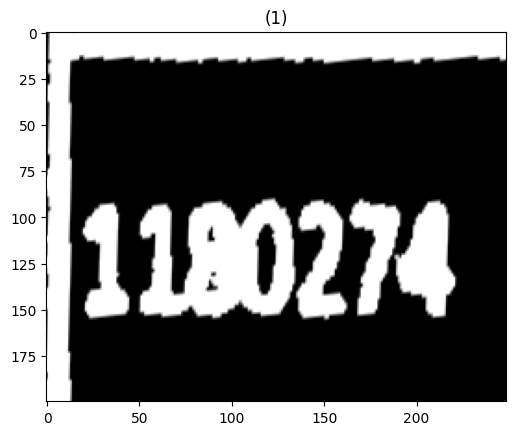

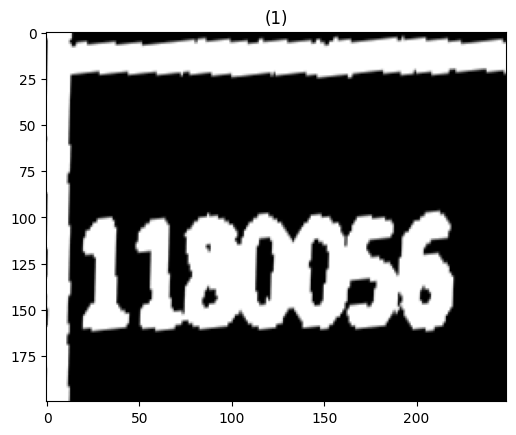

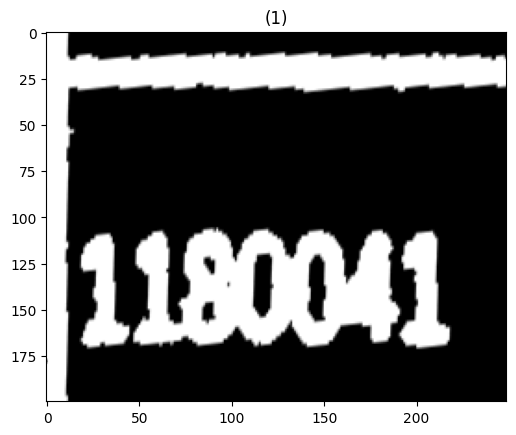

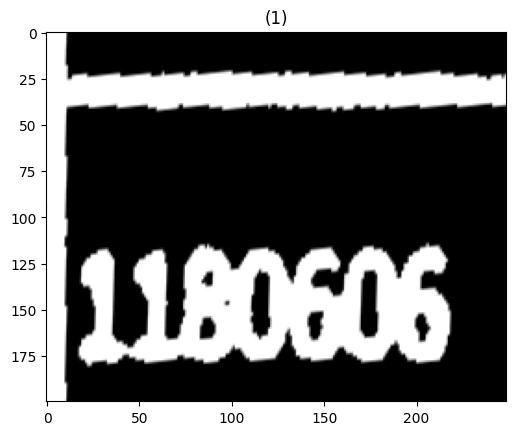

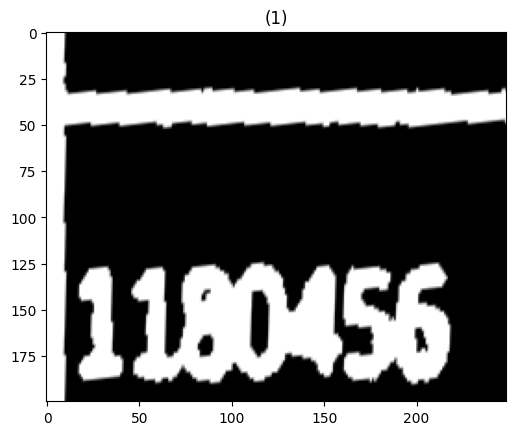

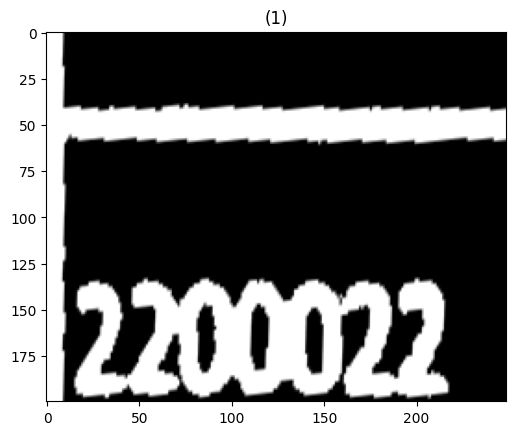

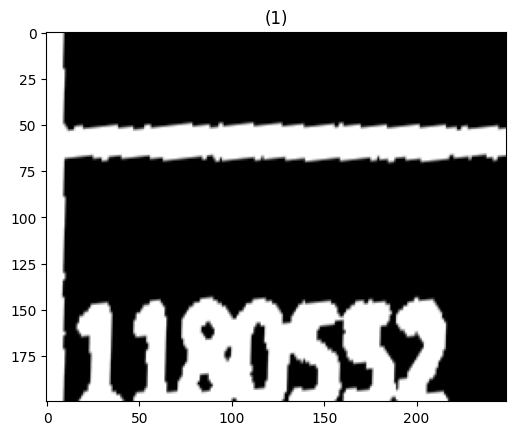

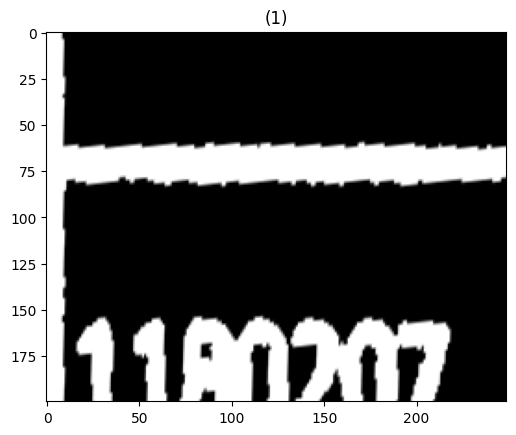

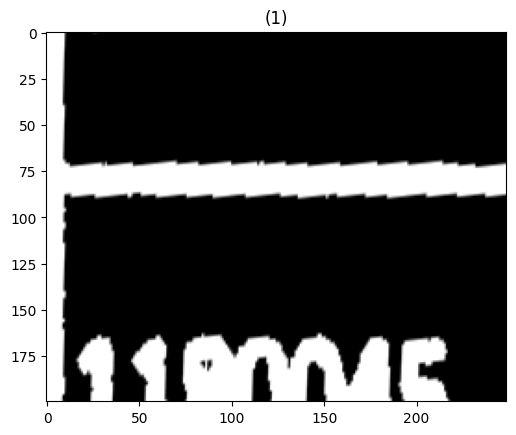

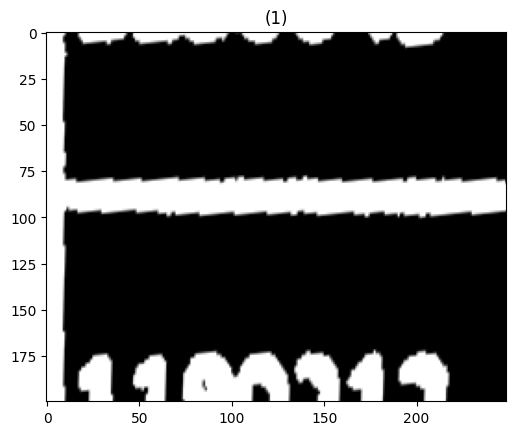

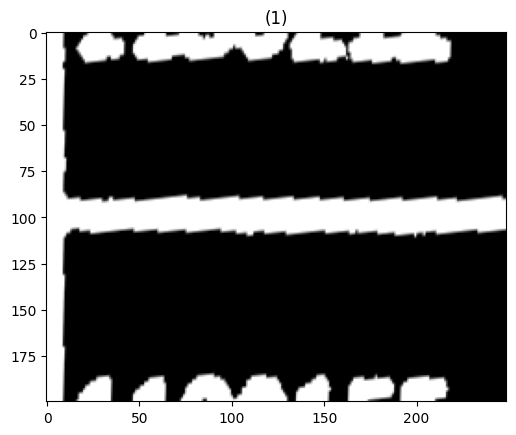

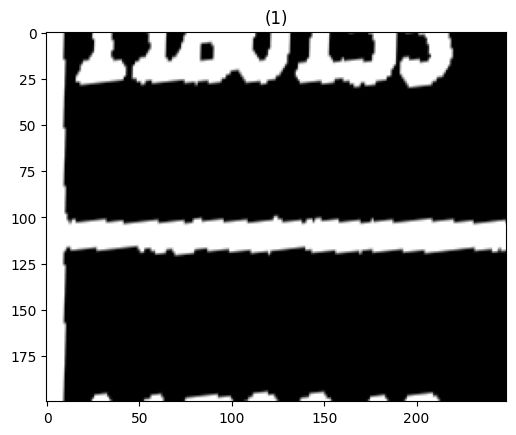

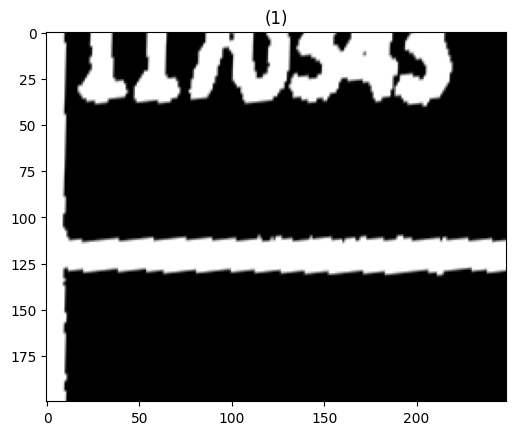

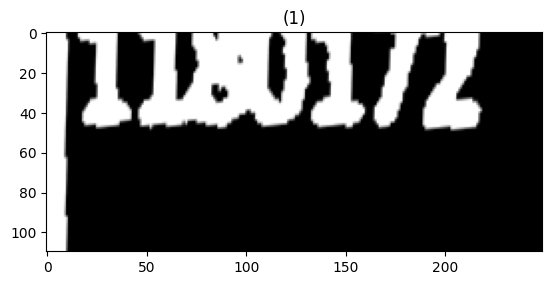

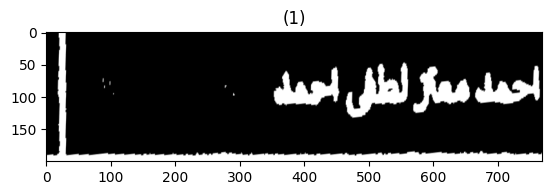

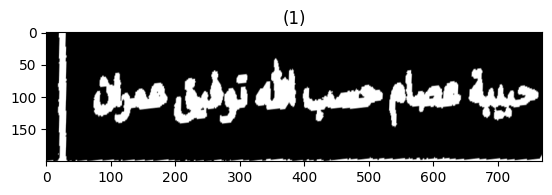

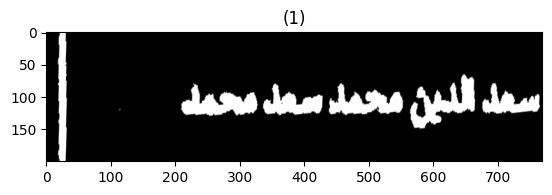

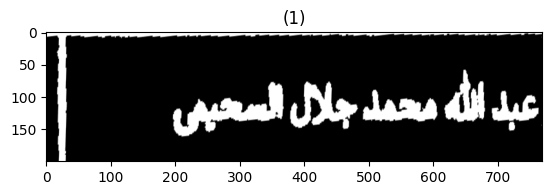

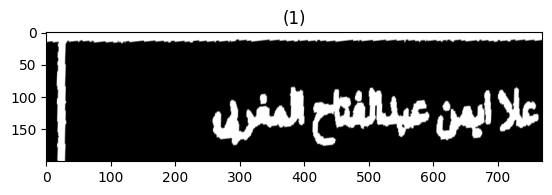

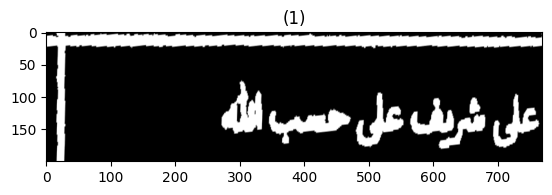

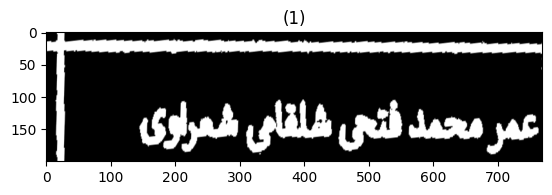

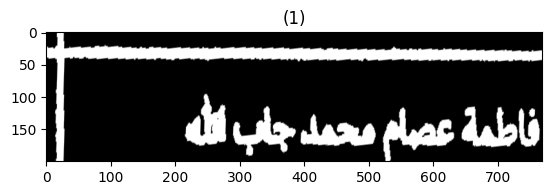

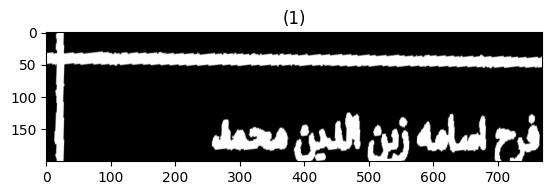

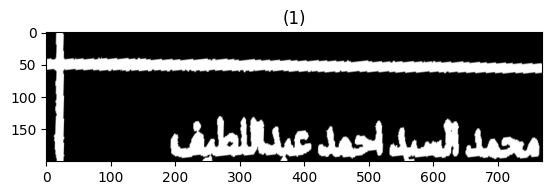

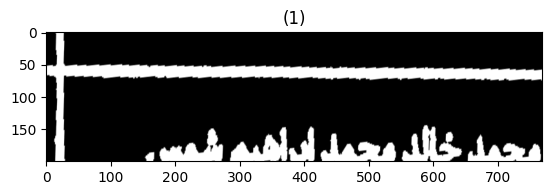

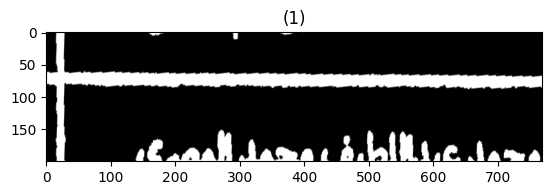

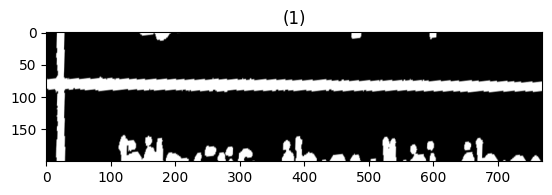

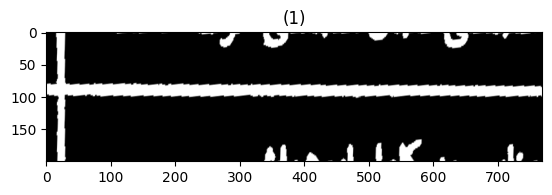

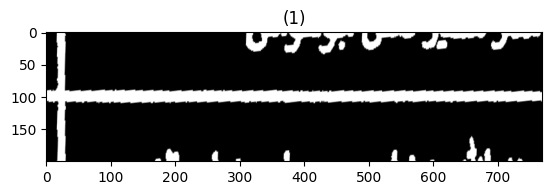

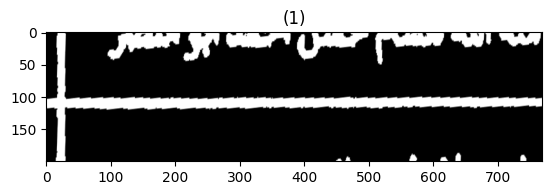

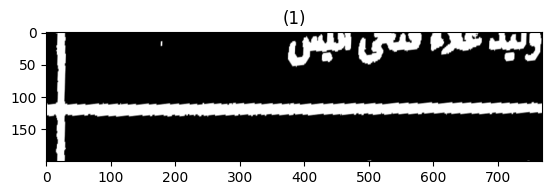

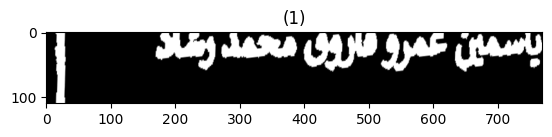

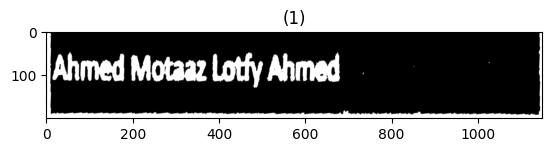

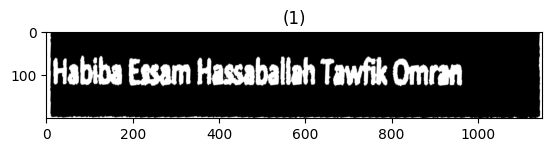

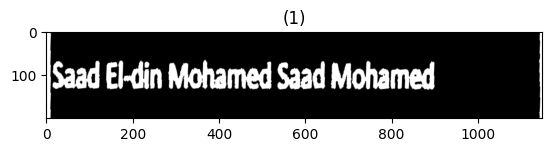

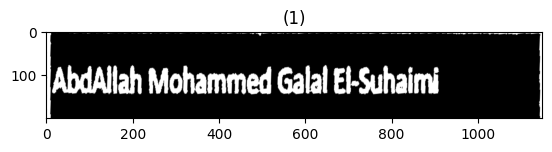

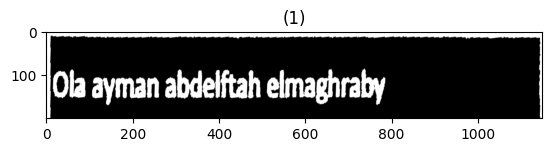

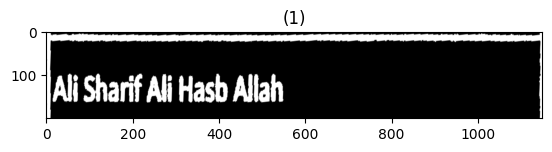

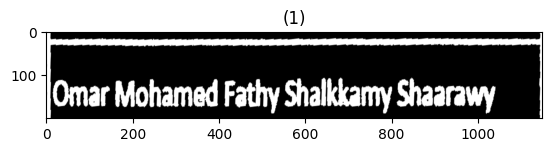

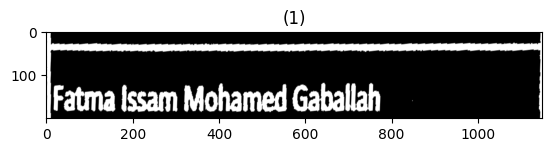

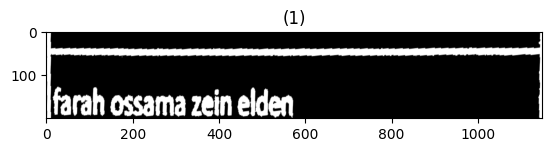

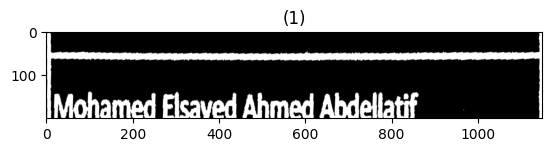

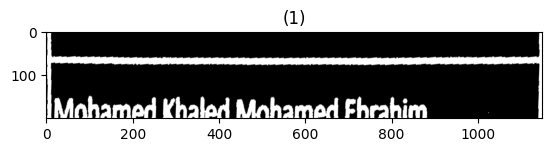

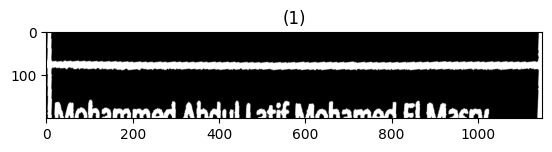

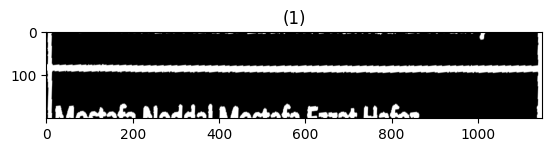

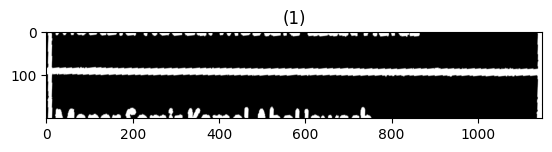

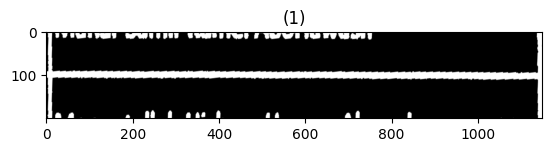

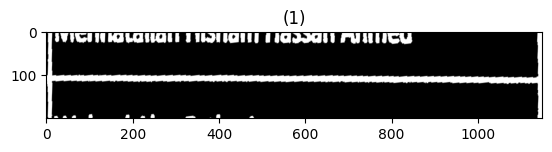

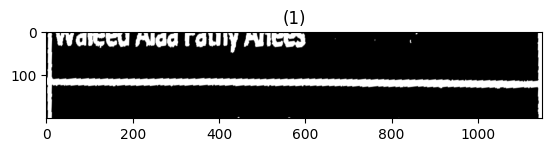

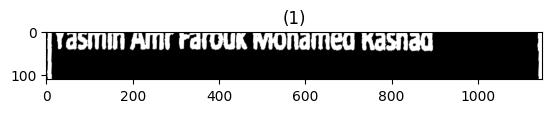

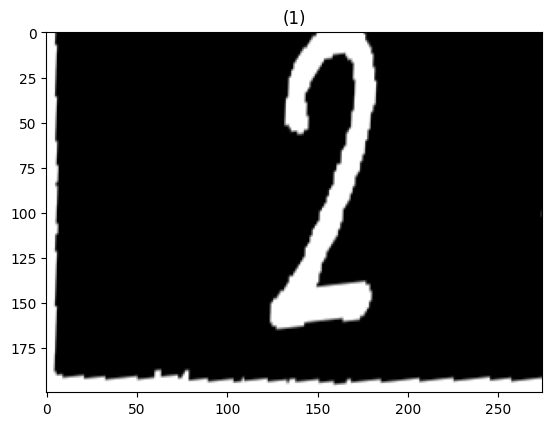

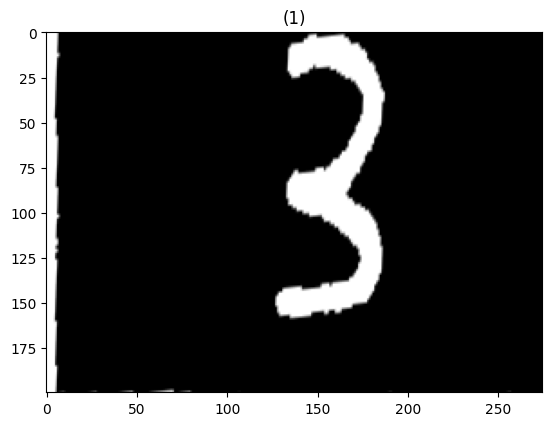

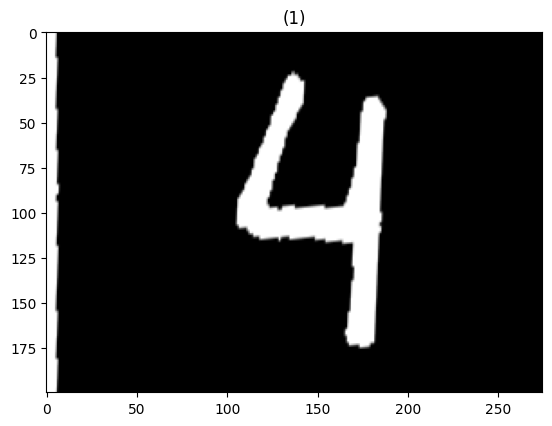

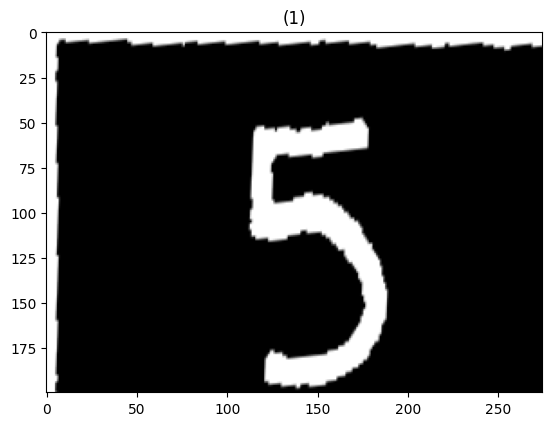

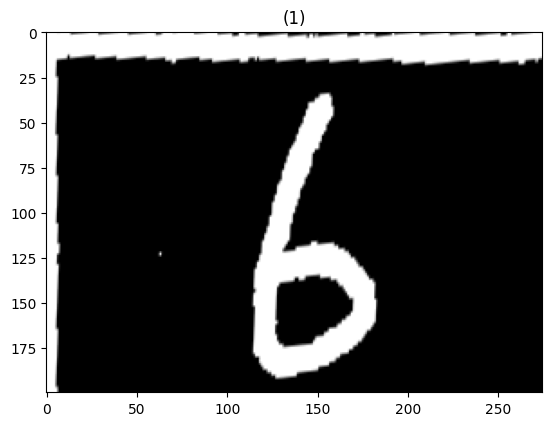

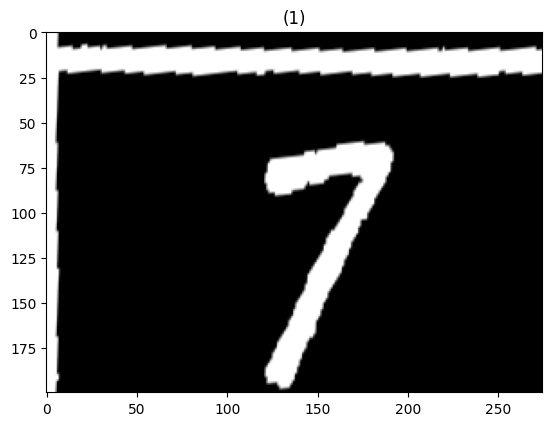

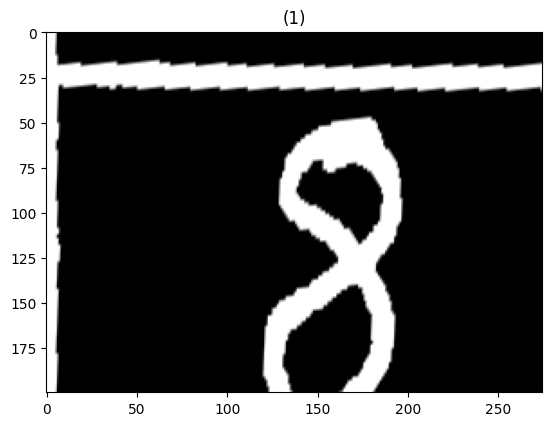

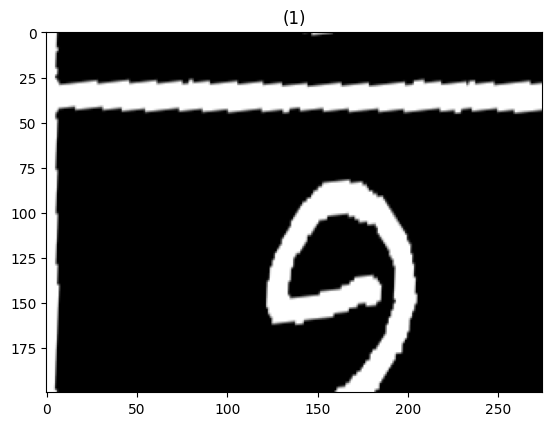

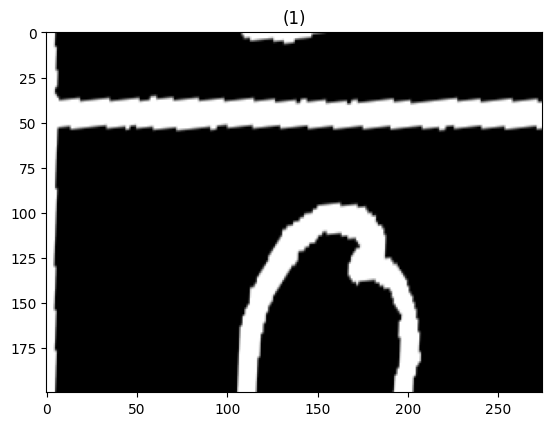

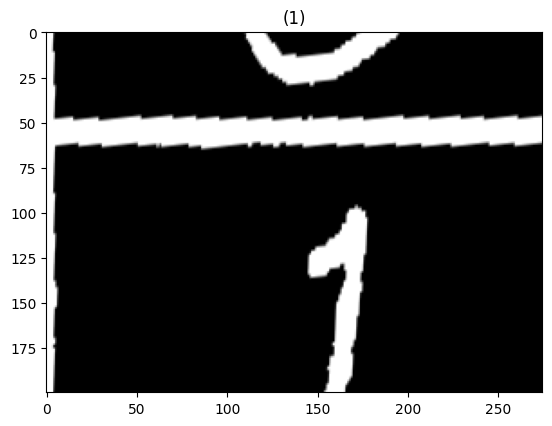

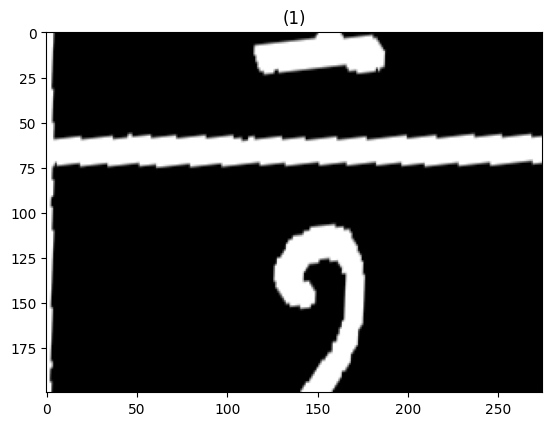

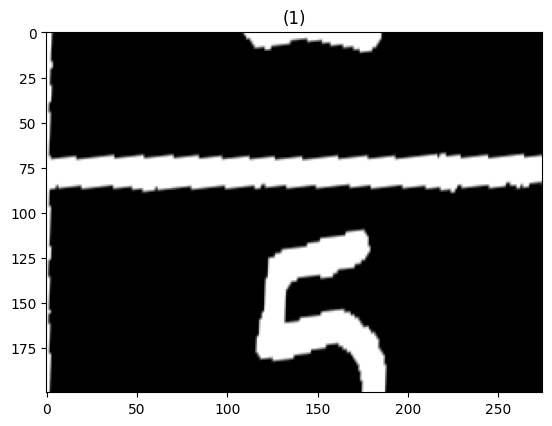

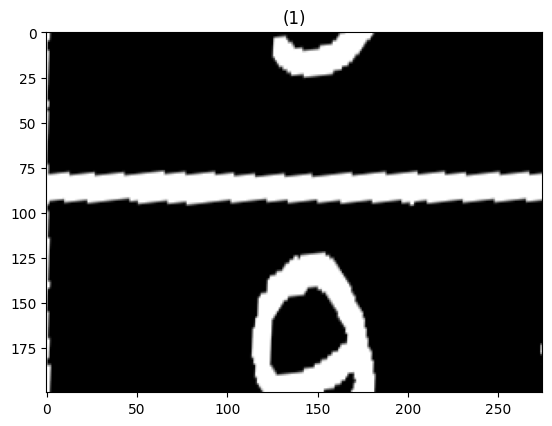

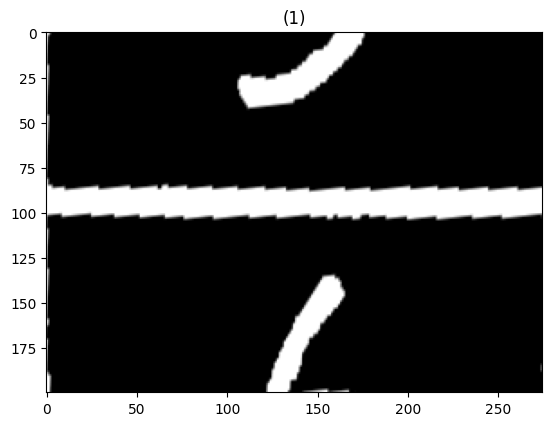

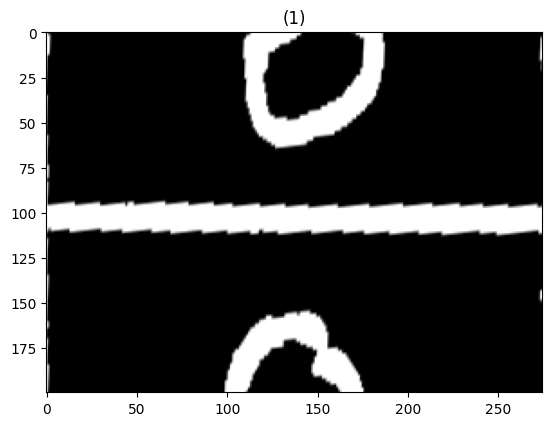

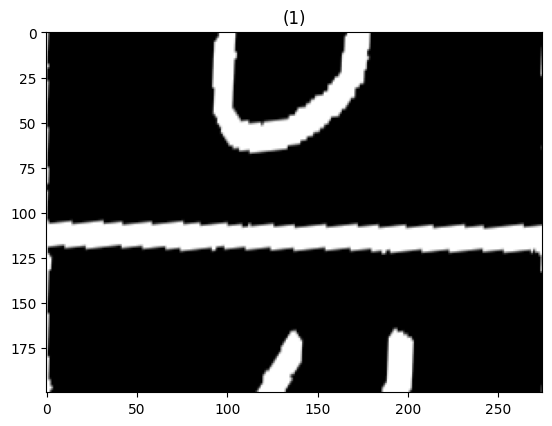

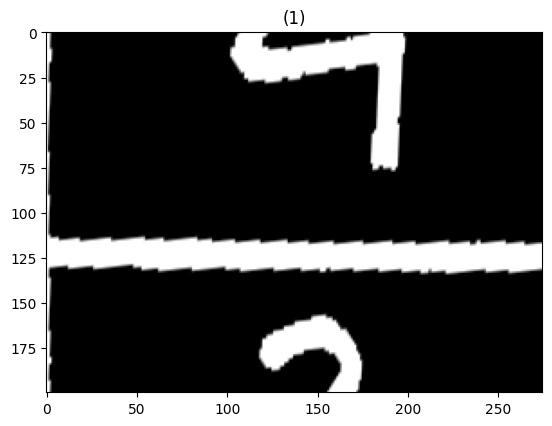

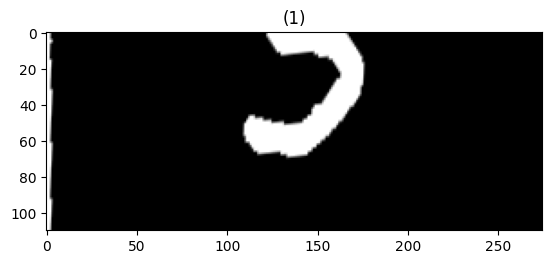

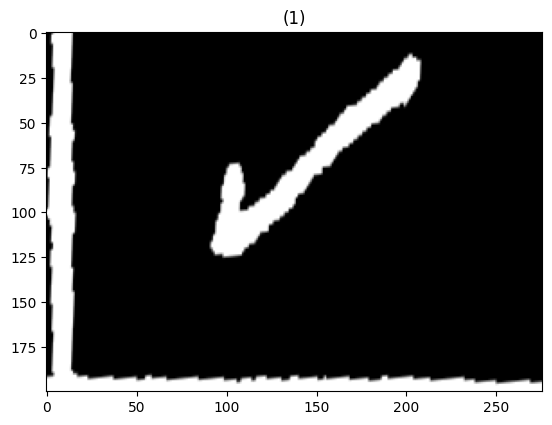

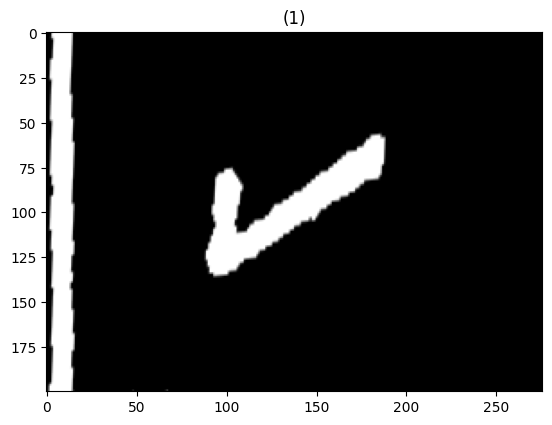

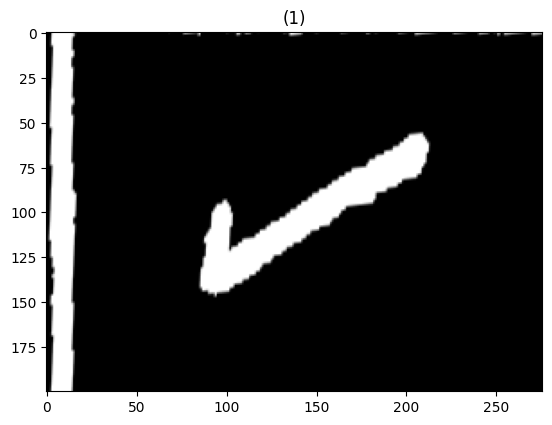

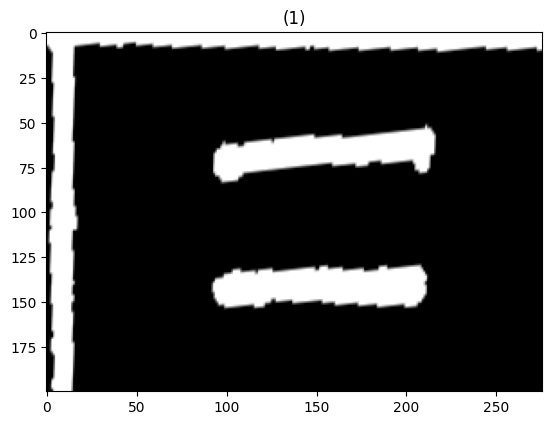

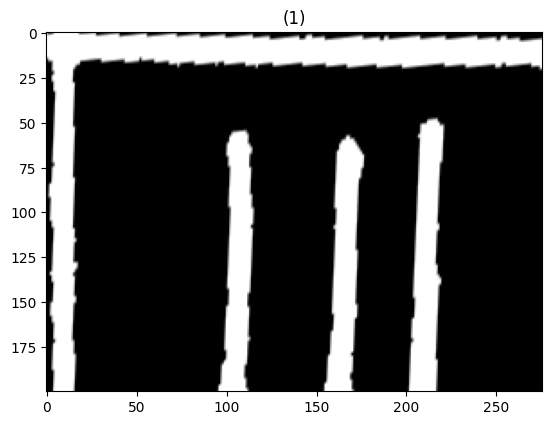

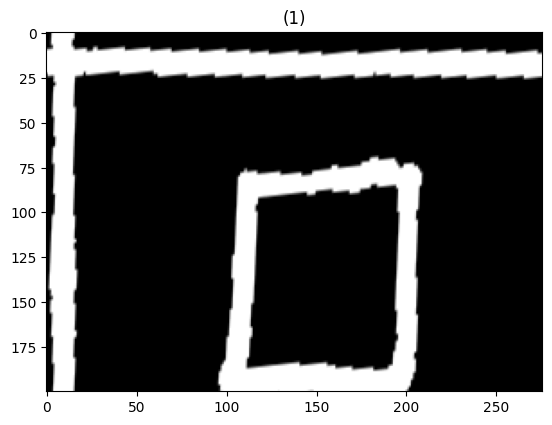

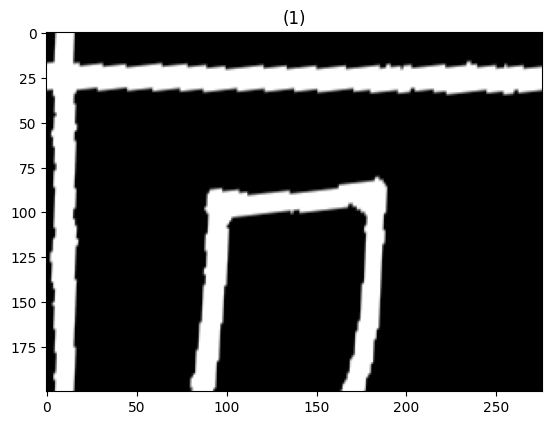

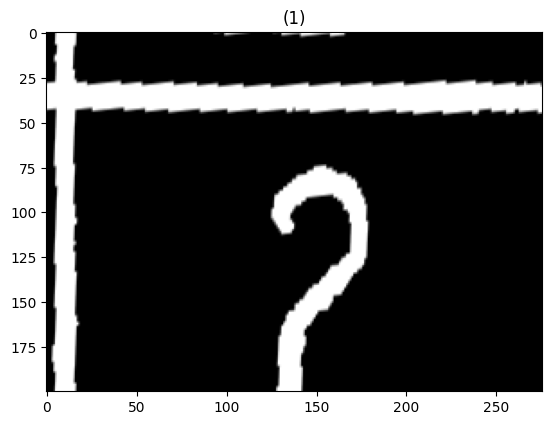

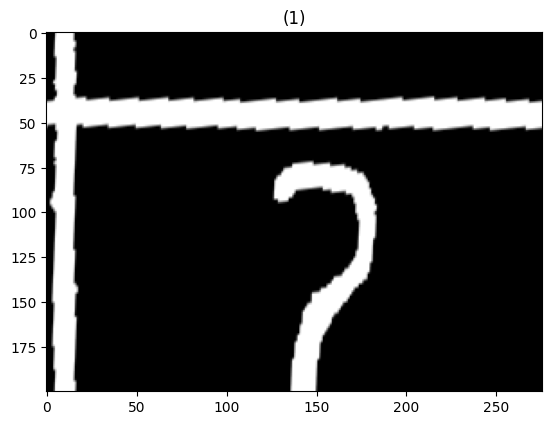

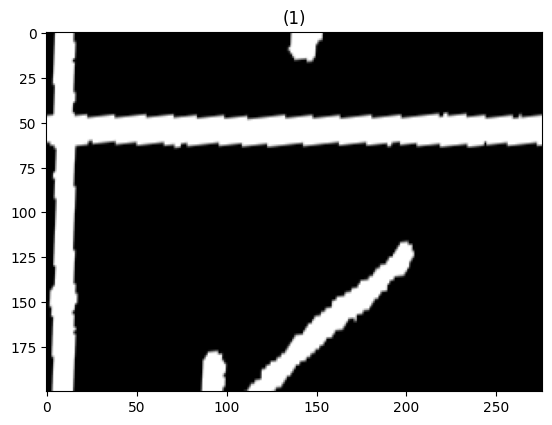

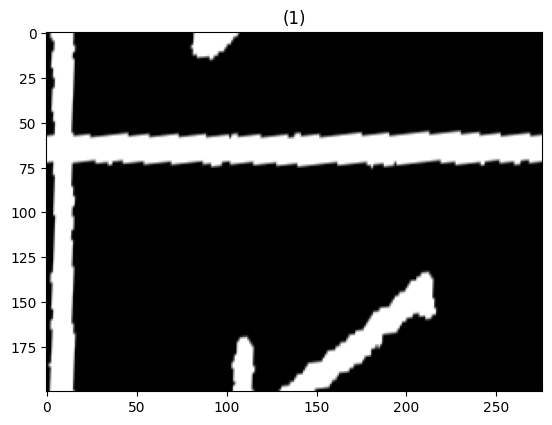

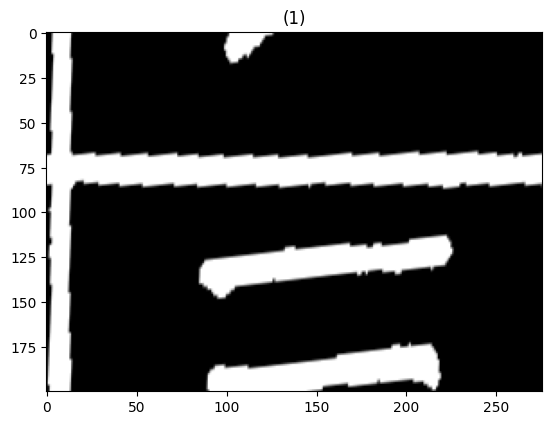

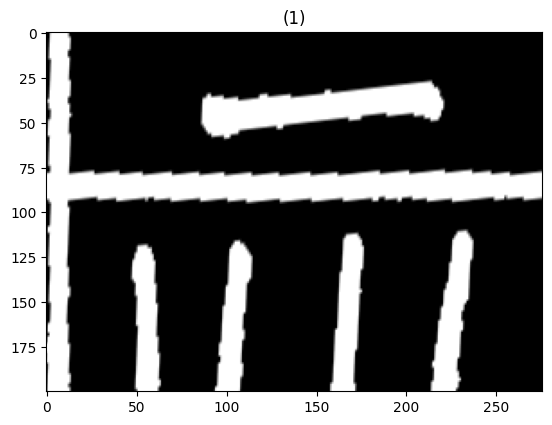

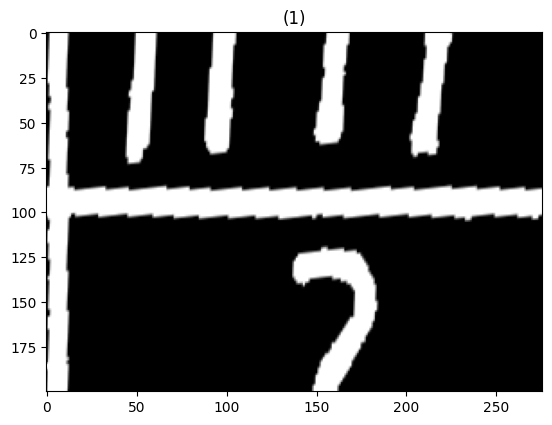

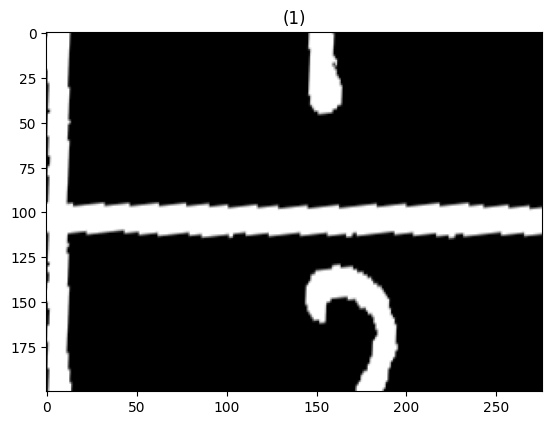

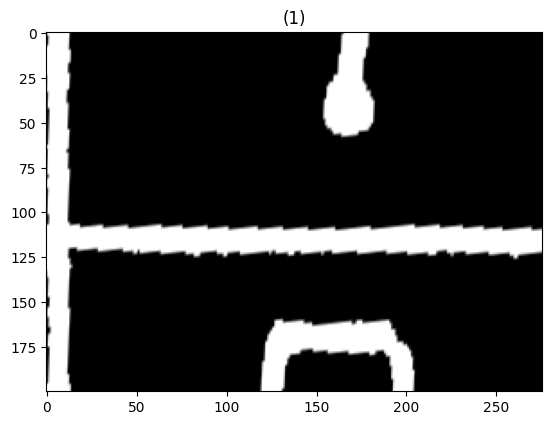

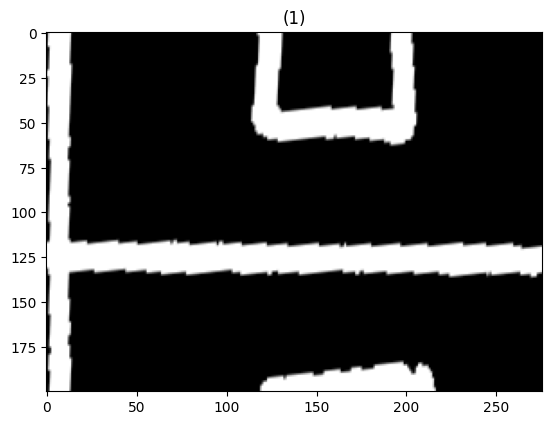

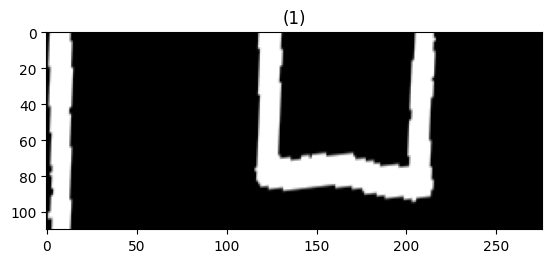

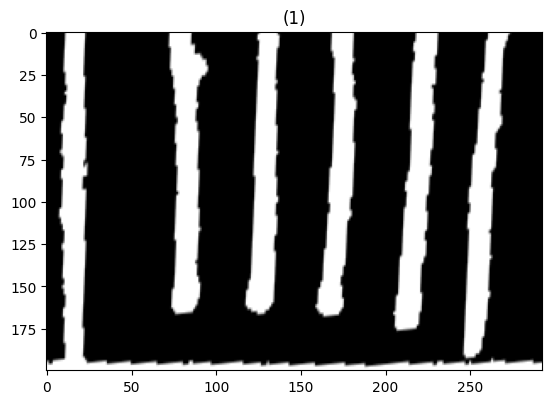

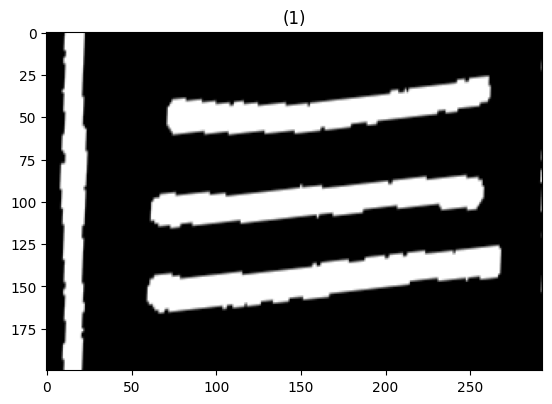

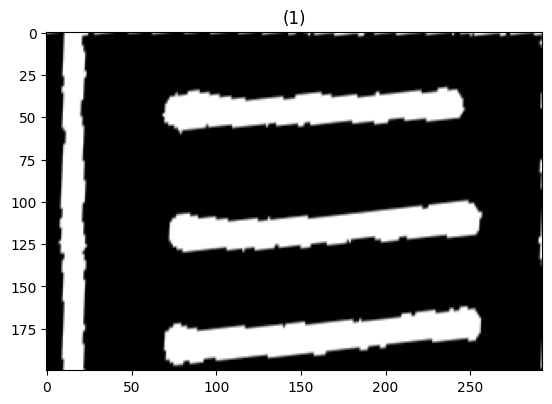

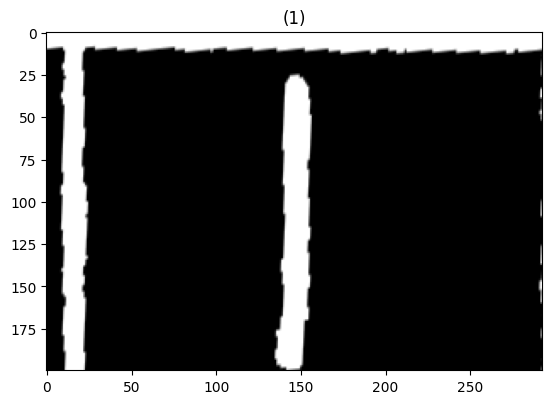

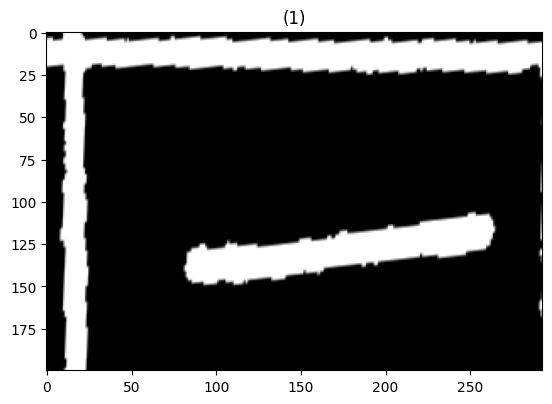

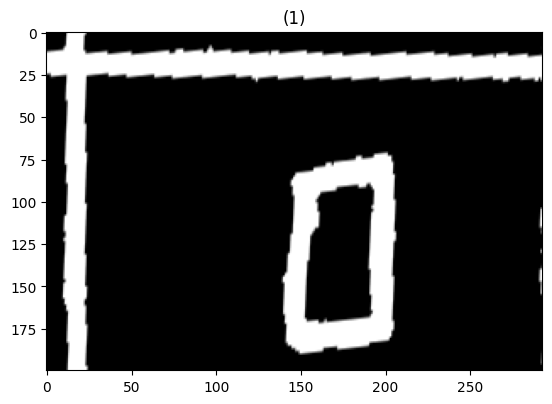

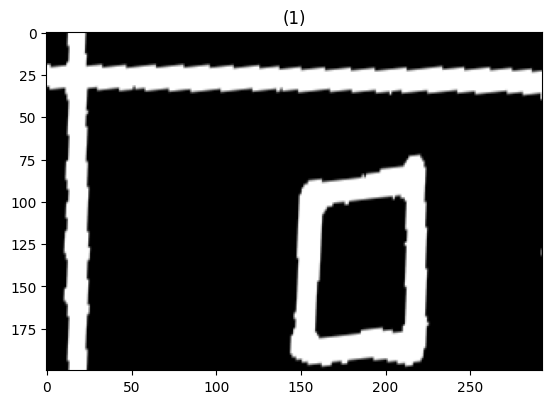

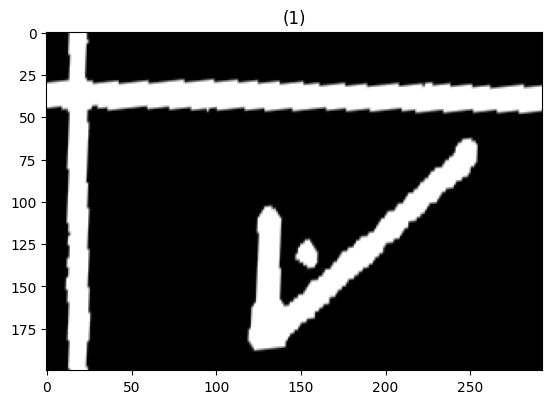

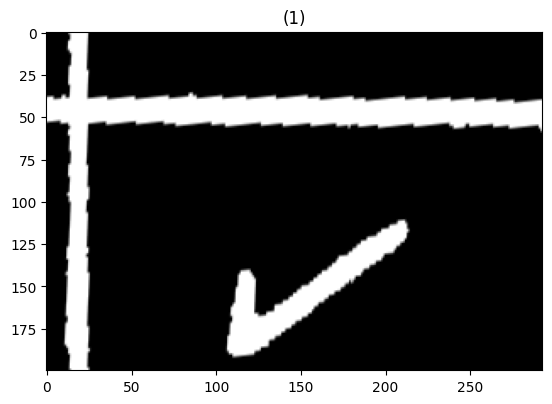

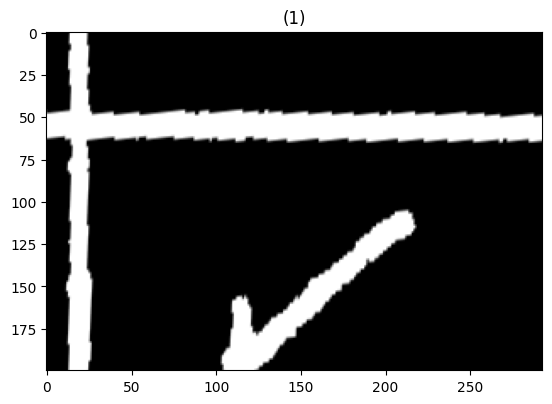

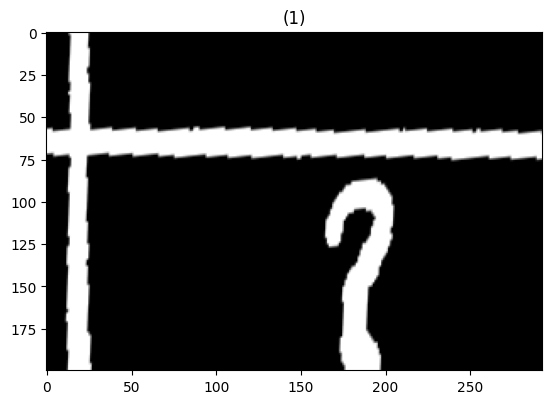

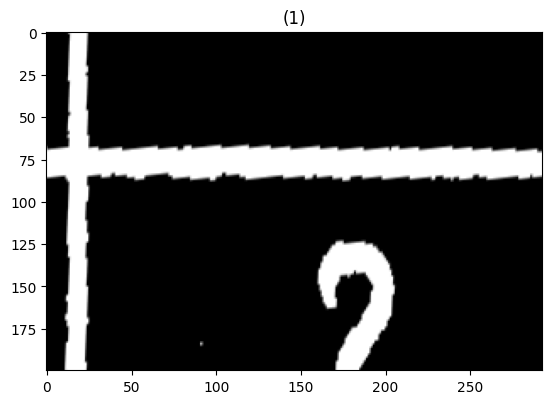

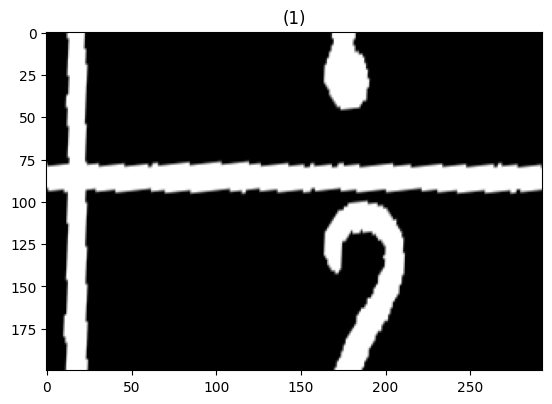

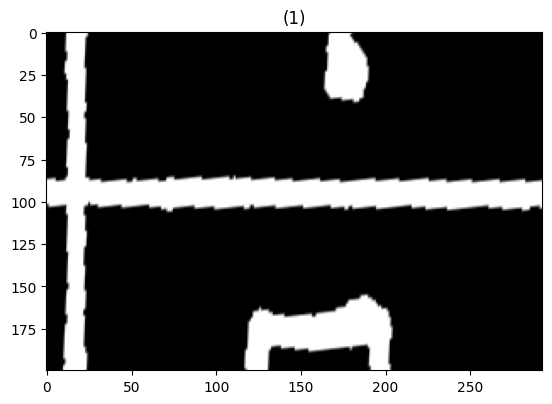

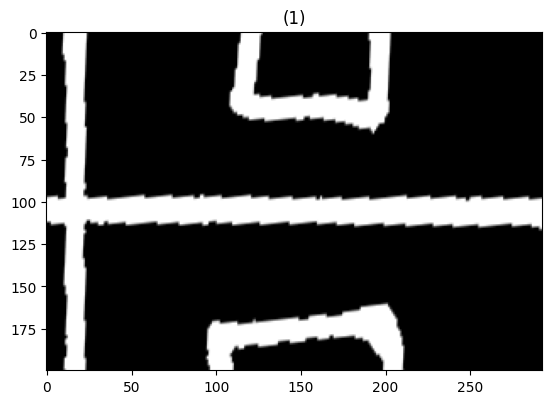

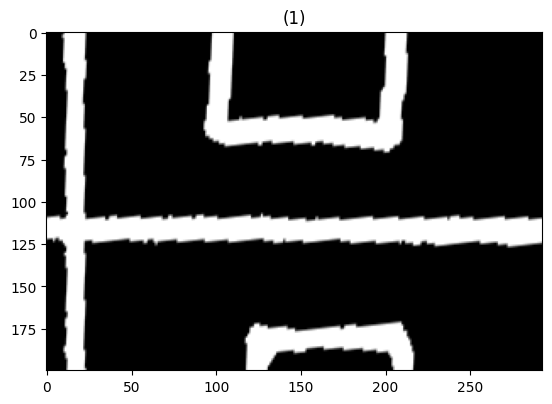

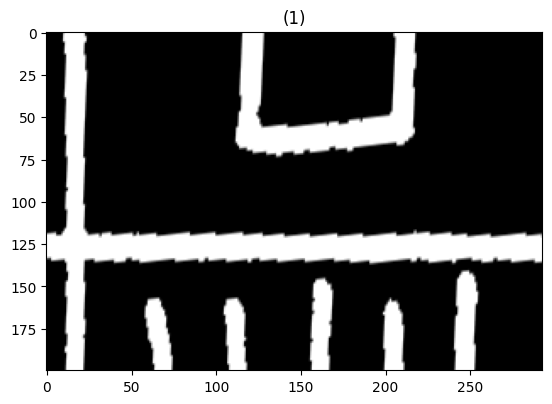

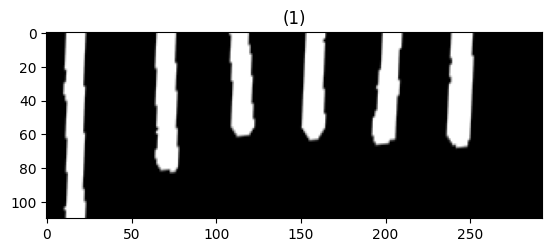

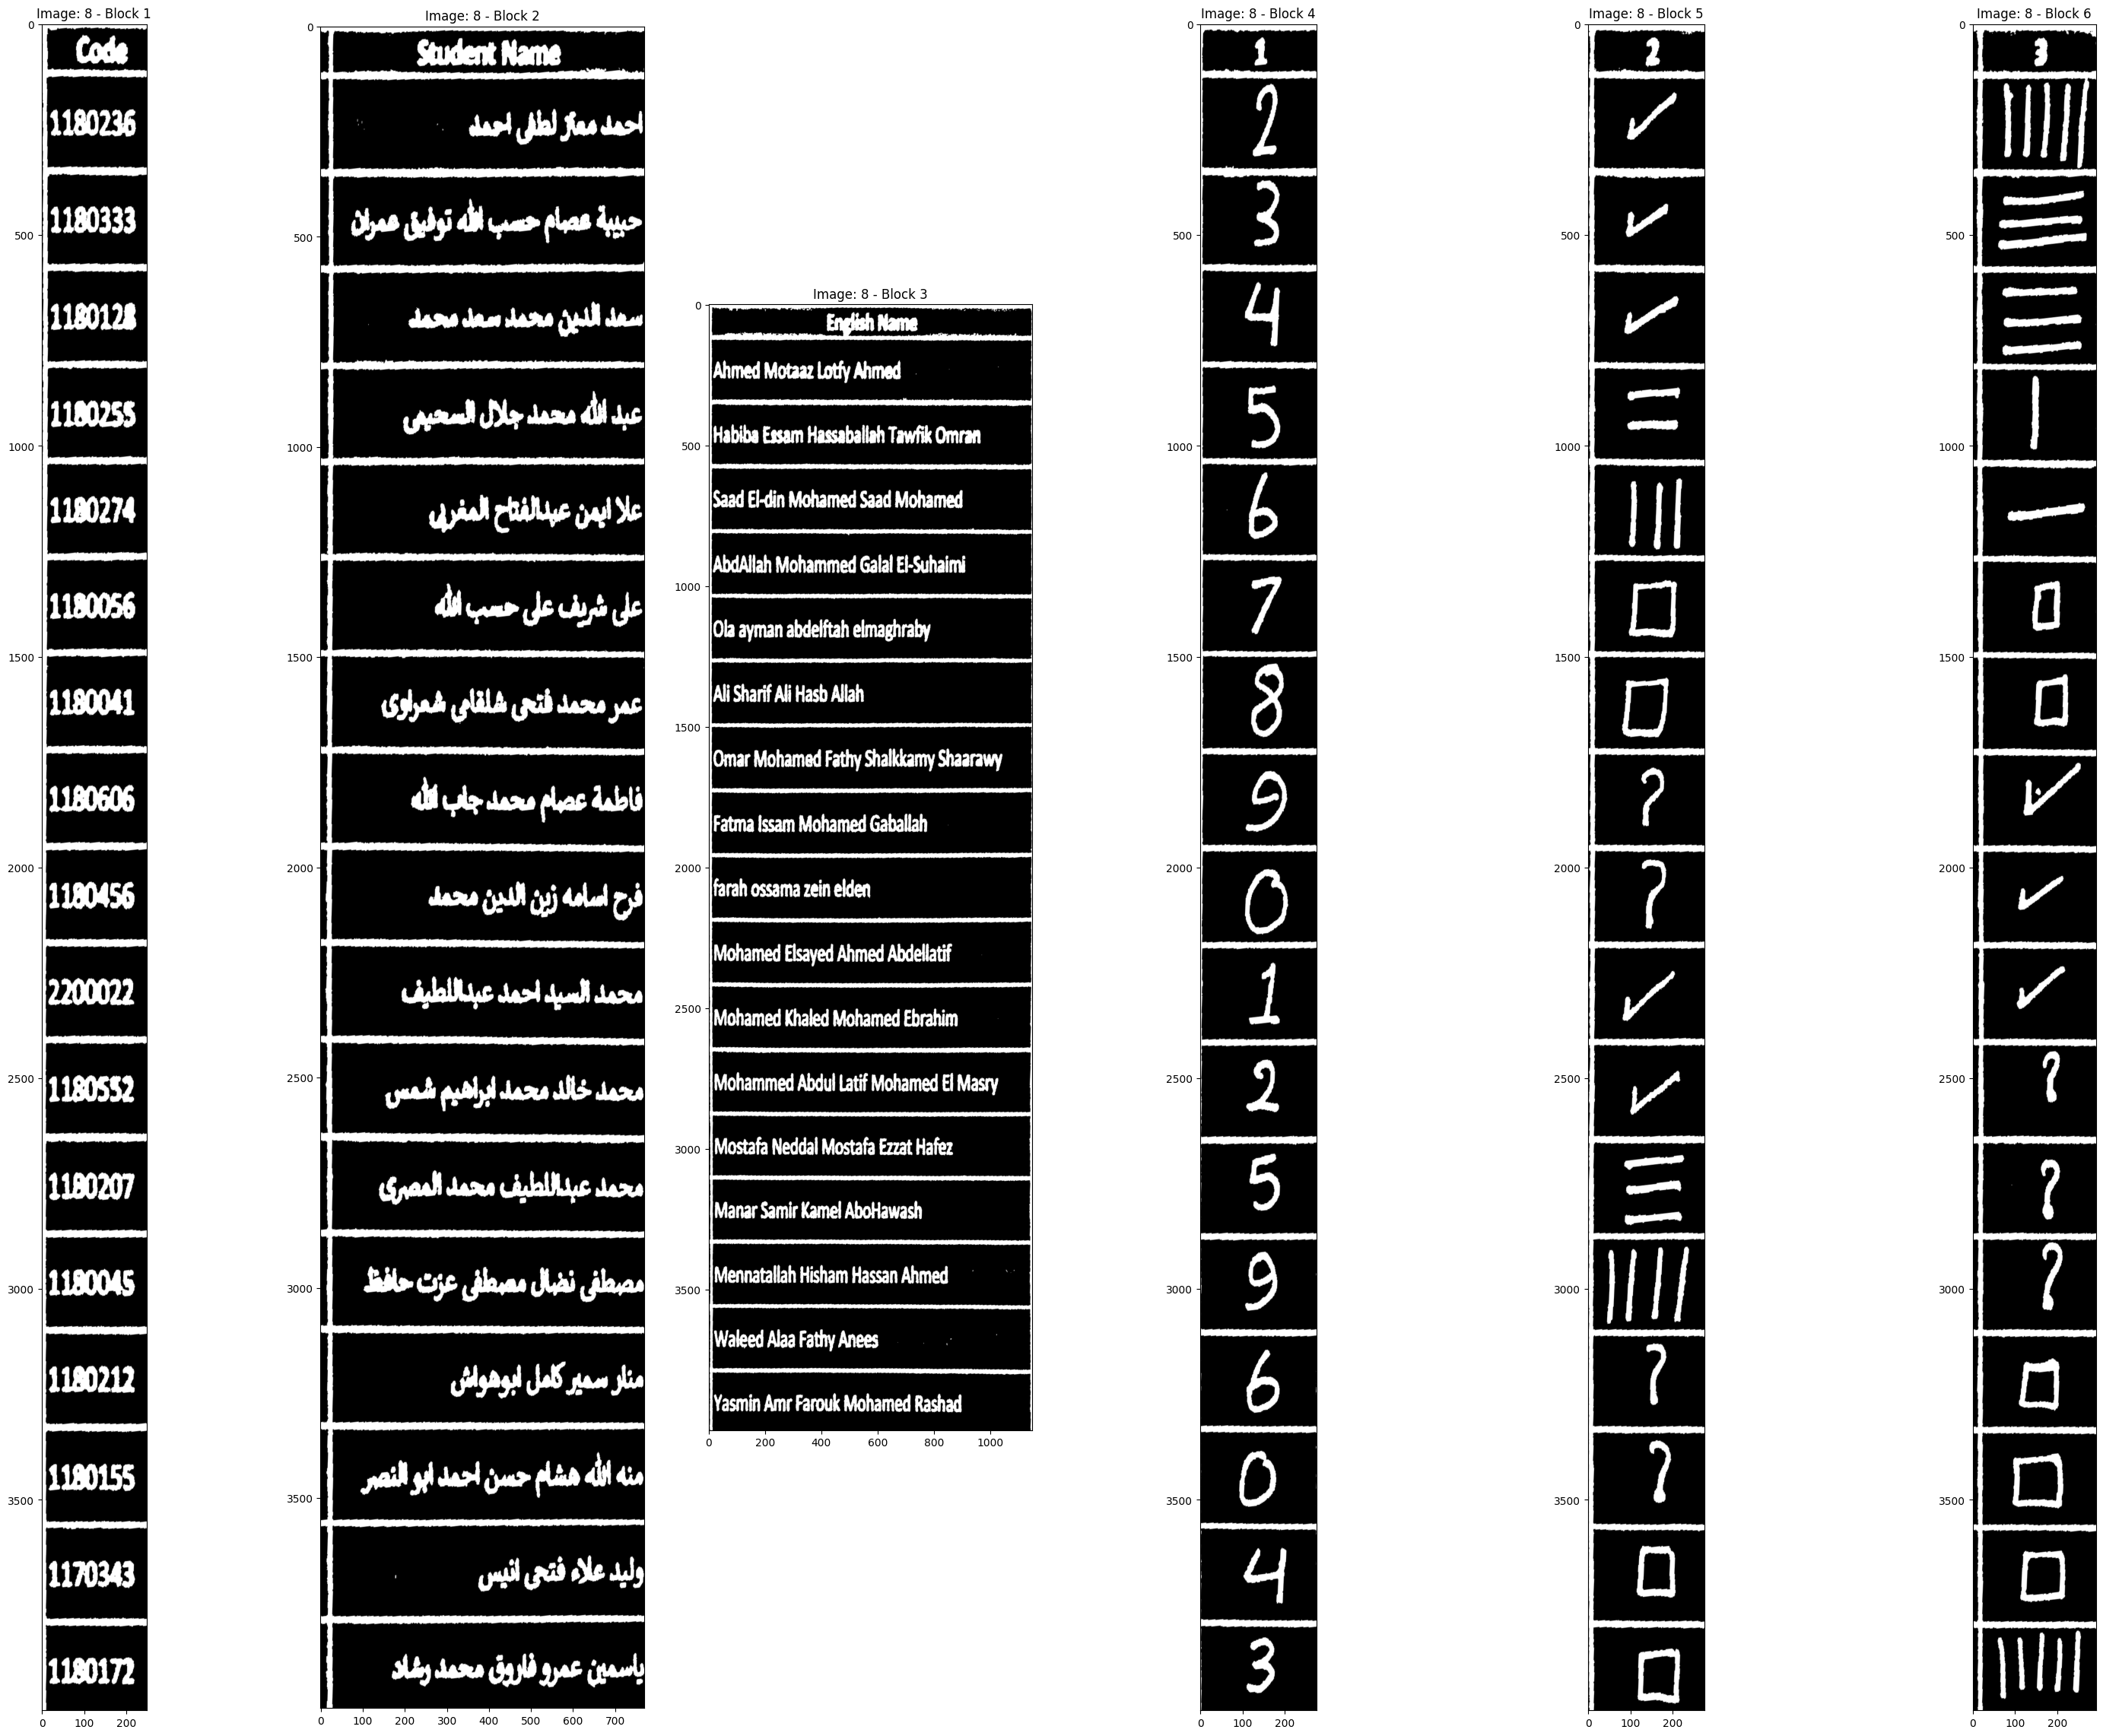

In [12]:
samples_dir = 'sheets'
for i in range(8,9):
    print(i)
    image_path = os.path.join(samples_dir, f"{i}.jpg")
    inverted_img = readImage(image_path)
    filtered_lines = getVerticalLines(inverted_img)
    blocks=getImageBlocks(filtered_lines, inverted_img)
    # for j in range (0,1):
    #     getcells(blocks[j])
    block_titles = [f"Image: {i} - Block {j+1}" for j in range(len(blocks))]
    show_images(blocks, block_titles)

Old trial

In [27]:
def load_image(file_path):
    try:
        # Load the image using OpenCV
        image = cv2.imread(file_path)
        if image is None:
            print("Error: Image not found. Check the file path.")
            return None

        # Display the image using OpenCV
        cv2.imshow('Loaded Bubble Sheet Image', image)
        show_images([image])

        cv2.waitKey(0)
        cv2.destroyAllWindows()

        return image
    
    except Exception as e:
        print(f"Error loading image: {e}")
        return None
    
# Function to resize the image to a target size while preserving aspect ratio
def resize_image(image, target_width=500, target_height=700):
    h, w = image.shape[:2]
    aspect_ratio = w / h

    if w > h:  # Wide image
        new_width = target_width
        new_height = int(target_width / aspect_ratio)
    else:  # Tall or square image
        new_height = target_height
        new_width = int(target_height * aspect_ratio)

    # Ensure dimensions don't exceed target size
    new_width = min(new_width, target_width)
    new_height = min(new_height, target_height)

    resized = cv2.resize(image, (new_width, new_height), interpolation=cv2.INTER_LANCZOS4)

    # Calculate padding to match target dimensions
    delta_w = max(target_width - new_width, 0)
    delta_h = max(target_height - new_height, 0)
    top, bottom = delta_h // 2, delta_h - (delta_h // 2)
    left, right = delta_w // 2, delta_w - (delta_w // 2)

    color = [0, 0, 0]  # Black padding
    padded_image = cv2.copyMakeBorder(resized, top, bottom, left, right, cv2.BORDER_CONSTANT, value=color)

    return padded_image


# Function to detect the outline of the sheet and apply perspective transform
def detect_sheet_contour(image, width=500, height=700):
    # Resize image for consistent dimensions (optional)
    #image = resize_image(image, target_width=width, target_height=height)

    # Convert to grayscale
    gray = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)

    # Apply Gaussian blur to reduce noise before edge detection
    blurred = cv2.GaussianBlur(gray, (5, 5), 0)

    # Apply Canny edge detection with adjusted thresholds
    edges = cv2.Canny(blurred, 50, 150)

    # Find contours
    contours, _ = cv2.findContours(edges, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)

    # Sort contours by area (largest first)
    contours = sorted(contours, key=cv2.contourArea, reverse=True)

    # Check if we have any contours
    if len(contours) > 0:
        # Assume the largest contour is the sheet (boundary of the Excel sheet)
        sheet_contour = contours[0]

        # Approximate the sheet's contour to a quadrilateral
        epsilon = 0.03 * cv2.arcLength(sheet_contour, True)  # Increased epsilon to make it more flexible
        approx = cv2.approxPolyDP(sheet_contour, epsilon, True)

        # Ensure we have 4 points (a quadrilateral)
        if len(approx) == 4:
            points = approx.reshape(4, 2)
            rect = np.zeros((4, 2), dtype='float32')

            # Sort points to ensure correct order
            s = points.sum(axis=1)
            rect[0] = points[np.argmin(s)]  # Top-left
            rect[2] = points[np.argmax(s)]  # Bottom-right

            diff = np.diff(points, axis=1)
            rect[1] = points[np.argmin(diff)]  # Top-right
            rect[3] = points[np.argmax(diff)]  # Bottom-left

            # Define the standard rectangle for the aligned sheet
            dst = np.array([
                [0, 0],
                [width - 1, 0],
                [width - 1, height - 1],
                [0, height - 1]
            ], dtype='float32')

            # Compute the perspective transform matrix
            M = cv2.getPerspectiveTransform(rect, dst)

            # Apply perspective warp to align the sheet
            aligned_sheet = cv2.warpPerspective(image, M, (width, height))

            # Display the aligned sheet
            cv2.imshow('Aligned Sheet', aligned_sheet)
            io.imshow(aligned_sheet)
            cv2.waitKey(0)
            cv2.destroyAllWindows()

            return aligned_sheet
        else:
            print("Sheet alignment failed: Unable to detect 4 corners.")
            return None
    else:
        print("No contours detected.")
        return None

In [ ]:
image_path = '13.jpg'
img = load_image(image_path)
processed_image = rgb2gray(detect_sheet_contour(img))

In [ ]:
smoothed_img = ski.filters.gaussian(processed_image, sigma=1)
io.imshow(smoothed_img)

In [ ]:
if smoothed_img.max() > 1:
    smoothed_img = smoothed_img / 255.0

# Apply Canny edge detection with adjusted thresholds
edge_img = ski.feature.canny(smoothed_img, sigma=1.5, high_threshold=0.1, low_threshold=0.05)
io.imshow(edge_img)

In [ ]:
edge_img2 = ski.filters.sobel(smoothed_img)
io.imshow(edge_img2)

In [ ]:
image_path = '1.jpg'
img = load_image(image_path)
edge_img3 = ski.feature.canny(rgb2gray(img), sigma=0.1, high_threshold=0.1, low_threshold=0.05)
io.imshow(edge_img3)